# Train the model

In [1]:
import os
import mlflow
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import AdaBoostRegressor,GradientBoostingRegressor,RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from xgboost.sklearn import XGBRegressor
import warnings
warnings.filterwarnings("ignore")



In [2]:
data = pd.read_csv('waiting_times_dataset.csv')
data = data[["TKIS_TIME","SERVICE_NAME", "QLength", "waiting_time_minutes"]]
# Convert TKIS_TIME to datetime
data['TKIS_TIME'] = pd.to_datetime(data['TKIS_TIME'], errors = 'coerce')

# Extract day name
data['Day_Name'] = data['TKIS_TIME'].dt.day_name()

# Extract time and classify as morning or evening
data['Time'] = data['TKIS_TIME'].dt.strftime('%H:%M:%S')
data['Period'] = data['TKIS_TIME'].apply(lambda x: 'Morning' if x.hour < 12 
                                         else 'Afternoon' if x.hour < 18 
                                         else 'Evening')
# Extract Date and Month
data['Day'] = pd.to_datetime(data['TKIS_TIME']).dt.day
data['Month'] = pd.to_datetime(data['TKIS_TIME']).dt.month
data.drop('TKIS_TIME', axis = 1, inplace=True)
data.sample(5)

,SERVICE_NAME,QLength,waiting_time_minutes,Day_Name,Time,Period,Day,Month
138495,Withdrawal (Current/SND),175,246.816667,Tuesday,14:40:16,Afternoon,13,4
69925,Deposit,51,178.416667,Sunday,13:01:13,Afternoon,6,12
214325,Customer(Mobile Banking),30,80.400000,Wednesday,15:32:04,Afternoon,6,10
20002,Withdrawal,13,78.500000,Tuesday,10:44:18,Morning,15,9
154423,Deposit,17,79.433333,Monday,10:34:36,Morning,24,5


In [3]:

from sklearn.preprocessing import LabelEncoder


# 1. Label encoding for SERVICE_NAME and Period
le_service_name = LabelEncoder()
le_period = LabelEncoder()

data['SERVICE_NAME'] = le_service_name.fit_transform(data['SERVICE_NAME'])
data['Period'] = le_period.fit_transform(data['Period'])

# 2. Extract Hour, Minute of Day from Time
data['Hour'] = pd.to_datetime(data['Time']).dt.hour
data['Minute_of_Day'] = pd.to_datetime(data['Time']).dt.hour * 60 + pd.to_datetime(data['Time']).dt.minute

# 3. Encode Day_Name numerically
day_mapping = {'Monday': 0, 'Tuesday': 1, 'Wednesday': 2, 'Thursday': 3, 'Friday': 4, 'Saturday': 5, 'Sunday': 6}
data['Day_of_Week'] = data['Day_Name'].map(day_mapping)

# 4. Create Is_Weekend feature
data['Is_Weekend'] = data['Day_Name'].apply(lambda x: 1 if x in ['Saturday', 'Sunday'] else 0)

# 5. Interaction features
data['Service_Day_Interaction'] = data['SERVICE_NAME'] * data['Day_of_Week']
data['Service_Hour_Interaction'] = data['SERVICE_NAME'] * data['Hour']
data['QLength_Period_Interaction'] = data['QLength'] * data['Period']

# 6. Log transformation on QLength
data['Log_QLength'] = np.log1p(data['QLength'])


# 8. Peak hour feature (assuming peak hours are 10 AM to 2 PM)
data['Is_Peak_Hour'] = data['Hour'].apply(lambda x: 1 if 10 <= x <= 14 else 0)

# Drop unnecessary columns
data.drop(['Time', 'Day_Name'], axis=1, inplace=True)

data.head()


,SERVICE_NAME,QLength,waiting_time_minutes,Period,Day,Month,Hour,Minute_of_Day,Day_of_Week,Is_Weekend,Service_Day_Interaction,Service_Hour_Interaction,QLength_Period_Interaction,Log_QLength,Is_Peak_Hour
0,14,0,0.000000,0,28,7,13,817,1,0,14,182,0,0.000000,1
1,28,1,0.216667,0,28,7,13,817,1,0,28,364,0,0.693147,1
2,27,0,0.000000,0,28,7,15,936,1,0,27,405,0,0.000000,0
3,12,0,0.000000,0,28,7,15,938,1,0,12,180,0,0.000000,0
4,3,1,18.766667,0,28,7,15,940,1,0,3,45,0,0.693147,0


In [4]:
# Convert waiting_time_minutes to 0 where QLength is 0
data.loc[data['QLength'] == 0, 'waiting_time_minutes'] = 0

In [5]:
max(data["QLength"])

537

In [6]:
data.shape

(280046, 15)

In [7]:
data.columns

Index(['SERVICE_NAME', 'QLength', 'waiting_time_minutes', 'Period', 'Day',
       'Month', 'Hour', 'Minute_of_Day', 'Day_of_Week', 'Is_Weekend',
       'Service_Day_Interaction', 'Service_Hour_Interaction',
       'QLength_Period_Interaction', 'Log_QLength', 'Is_Peak_Hour'],
      dtype='object')

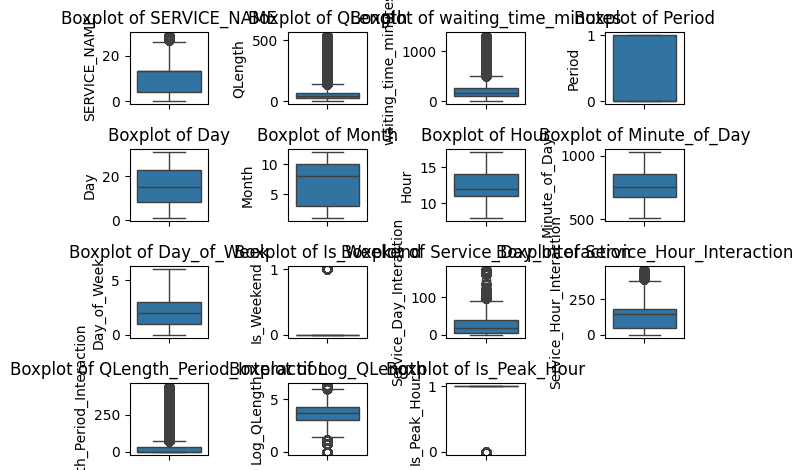

In [8]:
# Create a list of columns to plaot
columns = ['SERVICE_NAME', 'QLength', 'waiting_time_minutes', 'Period', 'Day',
       'Month', 'Hour', 'Minute_of_Day', 'Day_of_Week', 'Is_Weekend',
       'Service_Day_Interaction', 'Service_Hour_Interaction',
       'QLength_Period_Interaction', 'Log_QLength', 'Is_Peak_Hour']

# Plot each column
for i, column in enumerate(columns, 1):
    plt.subplot(4, 4, i)  # Adjust subplot parameters as needed
    sns.boxplot(y=data[column])
    plt.title(f'Boxplot of {column}')

plt.tight_layout()
plt.show()

In [9]:
features = data.columns
features

Index(['SERVICE_NAME', 'QLength', 'waiting_time_minutes', 'Period', 'Day',
       'Month', 'Hour', 'Minute_of_Day', 'Day_of_Week', 'Is_Weekend',
       'Service_Day_Interaction', 'Service_Hour_Interaction',
       'QLength_Period_Interaction', 'Log_QLength', 'Is_Peak_Hour'],
      dtype='object')

In [10]:
features = ['QLength', 'waiting_time_minutes','Service_Day_Interaction', 'Service_Hour_Interaction', 'QLength_Period_Interaction', 'Log_QLength']

In [11]:
def remove_outlier(train_data, cols):
    for col in cols:
        q1 = train_data[col].quantile(0.25)
        q3 = train_data[col].quantile(0.75)
        iqr = (q3 - q1)
        upper_limit = q3 + 1.5 * iqr
        lower_limit = q1 - 1.5 * iqr
        
        print(f"Column: {col}, Lower Limit: {lower_limit}, Upper Limit: {upper_limit}")
        
        # Replace outliers with NaN
        train_data[col] = np.where((train_data[col] < lower_limit) | (train_data[col] > upper_limit), np.nan, train_data[col])
        
        # Optional: Print outliers for verification
        outliers = train_data[(train_data[col] < lower_limit) | (train_data[col] > upper_limit)]
        print(f"Outliers in {col}: {outliers}")
        
    return train_data

data = remove_outlier(data, features)
data = data.dropna()
data = remove_outlier(data, features)
data = data.dropna()
data = remove_outlier(data, features)
data = data.dropna()
data = remove_outlier(data, features)


Column: QLength, Lower Limit: -52.0, Upper Limit: 140.0
Outliers in QLength: Empty DataFrame
Columns: [SERVICE_NAME, QLength, waiting_time_minutes, Period, Day, Month, Hour, Minute_of_Day, Day_of_Week, Is_Weekend, Service_Day_Interaction, Service_Hour_Interaction, QLength_Period_Interaction, Log_QLength, Is_Peak_Hour]
Index: []
Column: waiting_time_minutes, Lower Limit: -156.68333333333334, Upper Limit: 509.31666666666666
Outliers in waiting_time_minutes: Empty DataFrame
Columns: [SERVICE_NAME, QLength, waiting_time_minutes, Period, Day, Month, Hour, Minute_of_Day, Day_of_Week, Is_Weekend, Service_Day_Interaction, Service_Hour_Interaction, QLength_Period_Interaction, Log_QLength, Is_Peak_Hour]
Index: []
Column: Service_Day_Interaction, Lower Limit: -48.5, Upper Limit: 91.5
Outliers in Service_Day_Interaction: Empty DataFrame
Columns: [SERVICE_NAME, QLength, waiting_time_minutes, Period, Day, Month, Hour, Minute_of_Day, Day_of_Week, Is_Weekend, Service_Day_Interaction, Service_Hour_Inte

In [12]:
data.head()

,SERVICE_NAME,QLength,waiting_time_minutes,Period,Day,Month,Hour,Minute_of_Day,Day_of_Week,Is_Weekend,Service_Day_Interaction,Service_Hour_Interaction,QLength_Period_Interaction,Log_QLength,Is_Peak_Hour
6,10,3.0,19.666667,0,28,7,15,941,1,0,10.0,150.0,0.0,1.386294,0
7,1,4.0,22.550000,0,28,7,15,941,1,0,1.0,15.0,0.0,1.609438,0
8,13,5.0,31.766667,0,28,7,15,941,1,0,13.0,195.0,0.0,1.791759,0
9,4,4.0,30.883333,0,28,7,15,942,1,0,4.0,60.0,0.0,1.609438,0
10,4,5.0,30.916667,0,28,7,15,942,1,0,4.0,60.0,0.0,1.791759,0


In [13]:
data.shape

(170394, 15)

In [14]:
data.isnull().sum()

SERVICE_NAME                      0
QLength                        2599
waiting_time_minutes           1798
Period                            0
Day                               0
Month                             0
Hour                              0
Minute_of_Day                     0
Day_of_Week                       0
Is_Weekend                        0
Service_Day_Interaction           8
Service_Hour_Interaction          0
QLength_Period_Interaction    32331
Log_QLength                       0
Is_Peak_Hour                      0
dtype: int64

In [15]:
data = data.dropna()

In [16]:
data.shape

(133998, 15)

In [17]:
data.isnull().sum()

SERVICE_NAME                  0
QLength                       0
waiting_time_minutes          0
Period                        0
Day                           0
Month                         0
Hour                          0
Minute_of_Day                 0
Day_of_Week                   0
Is_Weekend                    0
Service_Day_Interaction       0
Service_Hour_Interaction      0
QLength_Period_Interaction    0
Log_QLength                   0
Is_Peak_Hour                  0
dtype: int64

In [18]:
# from sklearn.preprocessing import StandardScaler

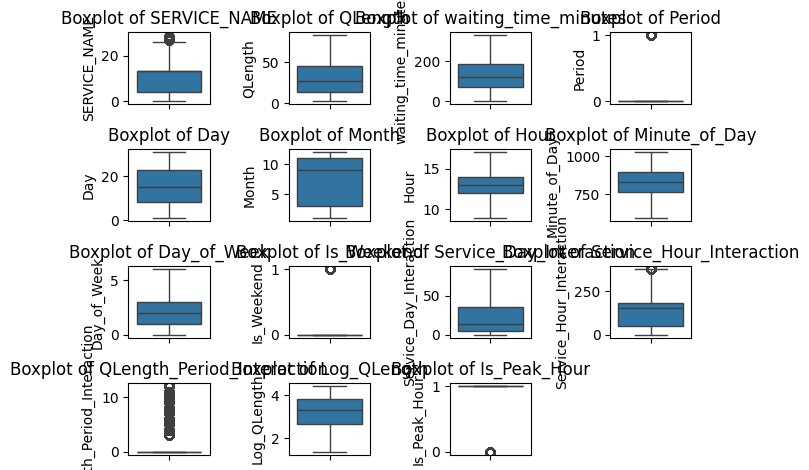

In [19]:

# Plot each column
for i, column in enumerate(columns, 1):
    plt.subplot(4, 4, i)  # Adjust subplot parameters as needed
    sns.boxplot(y=data[column])
    plt.title(f'Boxplot of {column}')

plt.tight_layout()
plt.show()

In [20]:
# Split the dataset
X = data.drop('waiting_time_minutes', axis=1)  # Features
y = data['waiting_time_minutes']  # Target

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

<Axes: >

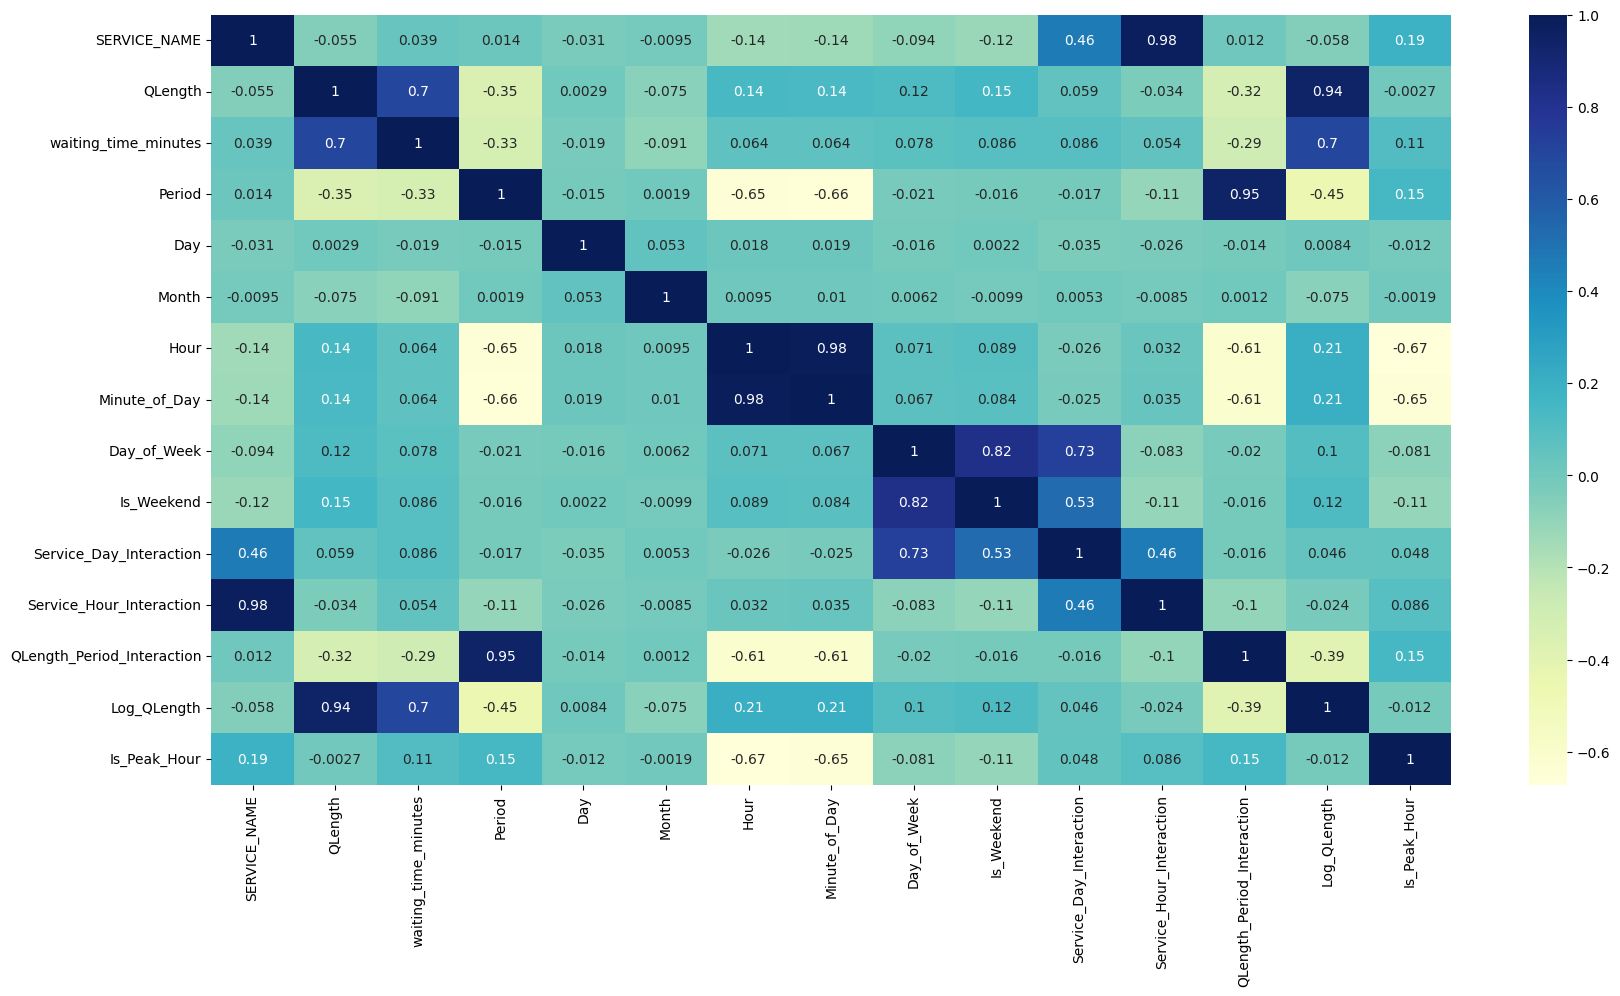

In [21]:
plt.figure(figsize=(20,10))

#plot heat map
sns.heatmap(data.corr(),annot=True,cmap="YlGnBu",linecolor='black')

In [22]:
waiting_time_minutes = data.corr()['waiting_time_minutes'].sort_values(ascending=False)
print(waiting_time_minutes)

waiting_time_minutes          1.000000
QLength                       0.698982
Log_QLength                   0.696204
Is_Peak_Hour                  0.106705
Service_Day_Interaction       0.086235
Is_Weekend                    0.086126
Day_of_Week                   0.078183
Minute_of_Day                 0.064460
Hour                          0.063558
Service_Hour_Interaction      0.054059
SERVICE_NAME                  0.039194
Day                          -0.019096
Month                        -0.091449
QLength_Period_Interaction   -0.292909
Period                       -0.328453
Name: waiting_time_minutes, dtype: float64


In [23]:
def correlation(dataset, threshold):
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    return col_corr


corr_features = correlation(X_train, 0.7)
len(set(corr_features))

6

In [24]:
corr_features

{'Is_Weekend',
 'Log_QLength',
 'Minute_of_Day',
 'QLength_Period_Interaction',
 'Service_Day_Interaction',
 'Service_Hour_Interaction'}

In [25]:
# X_train.drop(corr_features,axis=1, inplace=True)
# X_test.drop(corr_features,axis=1, inplace=True)


In [26]:
X_train

,SERVICE_NAME,QLength,Period,Day,Month,Hour,Minute_of_Day,Day_of_Week,Is_Weekend,Service_Day_Interaction,Service_Hour_Interaction,QLength_Period_Interaction,Log_QLength,Is_Peak_Hour
87719,27,43.0,0,5,1,14,859,1,0,27.0,378.0,0.0,3.784190,1
278107,3,19.0,0,27,2,14,871,6,1,18.0,42.0,0.0,2.995732,1
41110,27,8.0,1,22,10,10,624,3,0,81.0,270.0,8.0,2.197225,1
202700,16,20.0,0,14,9,15,904,1,0,16.0,240.0,0.0,3.044522,0
157635,13,14.0,0,31,5,13,825,0,0,0.0,169.0,0.0,2.708050,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233323,13,32.0,0,16,11,14,880,1,0,13.0,182.0,0.0,3.496508,1
252983,3,49.0,0,2,1,12,744,6,1,18.0,36.0,0.0,3.912023,1
216480,13,33.0,0,11,10,14,885,0,0,0.0,182.0,0.0,3.526361,1
276224,12,11.0,0,22,2,14,852,1,0,12.0,168.0,0.0,2.484907,1


# KNeighborsRegressor

In [27]:
# Initialize and train the KNeighborsRegressor model
# Best parameters found: {'algorithm': 'ball_tree', 'leaf_size': 30, 'n_neighbors': 10, 'p': 1, 'weights': 'distance'}
# Best score found: -5200.601247904665
knn_model = KNeighborsRegressor(n_neighbors= 10, algorithm='ball_tree', leaf_size=30, p= 1, weights= 'distance')
knn_model.fit(X_train, y_train)

# Make predictions
y_pred_knn = knn_model.predict(X_test)

# Evaluate the KNeighborsRegressor model
mse_knn = mean_squared_error(y_test, y_pred_knn)
rmse_knn = np.sqrt(mse_knn)
r2_knn = r2_score(y_test, y_pred_knn)

print("KNeighborsRegressor Mean Squared Error (MSE):", mse_knn)
print("KNeighborsRegressor Root Mean Squared Error (RMSE):", rmse_knn)
print("KNeighborsRegressor R^2 Score:", r2_knn)

KNeighborsRegressor Mean Squared Error (MSE): 773.3442522723011
KNeighborsRegressor Root Mean Squared Error (RMSE): 27.809067806604038
KNeighborsRegressor R^2 Score: 0.8669681054471378


# Random Forest Regression

In [28]:
# Initialize and train the Random Forest Regressor model
rf_model = RandomForestRegressor(n_estimators=400, max_depth=20, min_samples_split=5)
rf_model.fit(X_train, y_train)

# Make predictions
y_pred = rf_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)  # Root Mean Squared Error
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("R^2 Score:", r2)

# XGB Regressor

In [31]:
# Initialize the XGBRegressor
xgb = XGBRegressor()

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 250, 300],
    'learning_rate': [0.001, 0.1, 0.2, 0.3],
    'max_depth': [3, 5, 7, 13]
}
# Set up the GridSearchCV
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)
# Print the best parameters and best score
print("Best parameters found: ", grid_search.best_params_)
print("Best score found: ", grid_search.best_score_)
# Make predictions
y_pred = grid_search.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)  # Root Mean Squared Error
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("R^2 Score:", r2)

In [33]:
# Initialize and train the Random Forest Regressor model
xgb_model = XGBRegressor(n_estimators= 150, learning_rate= 0.1, max_depth= 13)
xgb_model.fit(X_train, y_train)

# Make predictions
y_pred = xgb_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)  # Root Mean Squared Error
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("R^2 Score:", r2)

Mean Squared Error (MSE): 168.89678192584572
Root Mean Squared Error (RMSE): 12.996029467719966
R^2 Score: 0.9709461099407442


# MLflow

In [39]:
# Model evelaution metrics
def eval_metrics(actual, pred):
    rmse = mean_squared_error(actual,pred,squared=False)
    mae = mean_absolute_error(actual,pred)
    r2 = r2_score(actual,pred)
    
    return(rmse, mae, r2)

In [40]:
mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("Waiting_Time_Prediction_Model")
from mlflow.data.pandas_dataset import PandasDataset

# Create an instance of a PandasDataset
dataset = mlflow.data.from_pandas(
    data, name="QPro Dataset", targets="waiting_time_minutes"
)

In [41]:
def mlflow_logging(model, X, y, name):
    with mlflow.start_run() as run:
        run_id = run.info.run_id
        print(run)
        mlflow.set_tag('Version', run_id)
        mlflow.log_input(dataset, context="training")
        pred = model.predict(X)
        #metrics
        (rmse, mae, r2) = eval_metrics(y, pred)
        mlflow.log_metric("RMSE", rmse)
        mlflow.log_metric("MAE", mae)
        mlflow.log_metric("R2", r2)
        # model
        mlflow.sklearn.log_model(model, artifact_path="model")
        mlflow.log_artifact("waiting_times_dataset.csv", "data")
        
    
    mlflow.end_run()

In [42]:
mlflow.__version__

'2.16.0'

In [ ]:
# mlflow_logging(rf_model, X_test, y_test, 'Random_Forest_Regressor')
mlflow_logging(xgb_model, X_test, y_test, 'XGB_Regression')
mlflow_logging(knn_model, X_test, y_test, 'KNeighborsRegressor')
mlflow_logging(rf_model, X_test, y_test, 'RandomForestRegressor')